## **EXPERIMENT-**
## Aim:
Age Prediction
> By Training CNN with dataset  

Dataset consists of 19k+ images of Actors  
Dataset also includes a CSV file containing info about whether the actor in the image is `old`, `middle aged` or `young` to verify

#### Importing the libraries:

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Checking availability of GPU:

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [2]:
# read the csv file to check out the images and class
data = pd.read_csv("/kaggle/input/faces-age-detection-dataset/train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [3]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(3)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1


In [4]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [5]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [6]:
# built the list of image paths and list of respective responses of the images
PATH = "/kaggle/input/faces-age-detection-dataset/Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

19906
19906


In [7]:
# split the dataset into train and test dataset
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

17915


2022-12-20 01:06:32.679422: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 01:06:32.789824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 01:06:32.790606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 01:06:32.793040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
# build the layers of CNN model
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

#### view the summary of the CNN model


In [11]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 30)      840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        17344     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5607488   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

#### compile the model

In [12]:

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# fit the model
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10


2022-12-20 01:06:36.502636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-20 01:06:37.895940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


280/280 [==============================] - 69s 221ms/step - loss: 0.8355 - accuracy: 0.6290 - val_loss: 0.7303 - val_accuracy: 0.6844
Epoch 2/10
280/280 [==============================] - 22s 78ms/step - loss: 0.7196 - accuracy: 0.6803 - val_loss: 0.6712 - val_accuracy: 0.7158
Epoch 3/10
280/280 [==============================] - 22s 78ms/step - loss: 0.6548 - accuracy: 0.7196 - val_loss: 0.6064 - val_accuracy: 0.7478
Epoch 4/10
280/280 [==============================] - 21s 76ms/step - loss: 0.5867 - accuracy: 0.7531 - val_loss: 0.5518 - val_accuracy: 0.7736
Epoch 5/10
280/280 [==============================] - 22s 80ms/step - loss: 0.5148 - accuracy: 0.7843 - val_loss: 0.4891 - val_accuracy: 0.7977
Epoch 6/10
280/280 [==============================] - 21s 76ms/step - loss: 0.4558 - accuracy: 0.8149 - val_loss: 0.4485 - val_accuracy: 0.8199
Epoch 7/10
280/280 [==============================] - 22s 78ms/step - loss: 0.3864 - accuracy: 0.8474 - val_loss: 0.4158 - val_accuracy: 0.8371
Ep

In [14]:
cnn_model.evaluate(train_set)

280/280 [==============================] - 11s 38ms/step - loss: 0.3456 - accuracy: 0.8626


[0.3456118404865265, 0.8625732660293579]

In [15]:
# test accuracy
cnn_model.evaluate(test_set)

280/280 [==============================] - 10s 36ms/step - loss: 0.4470 - accuracy: 0.8421


[0.4470181465148926, 0.8420964479446411]

In [16]:
test_pred = cnn_model.predict(test_set)

In [17]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])


Test Predictions response sample: [0, 0, 1, 1, 1, 1, 1, 1, 0, 1]
Test True response sample: [0, 0, 1, 1, 1, 1, 0, 1, 0, 1]


In [18]:
class_names = ['YOUNG','MIDDLE','OLD']

In [19]:
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

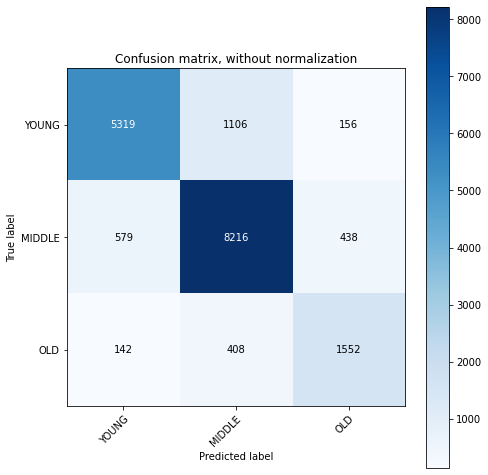

In [20]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

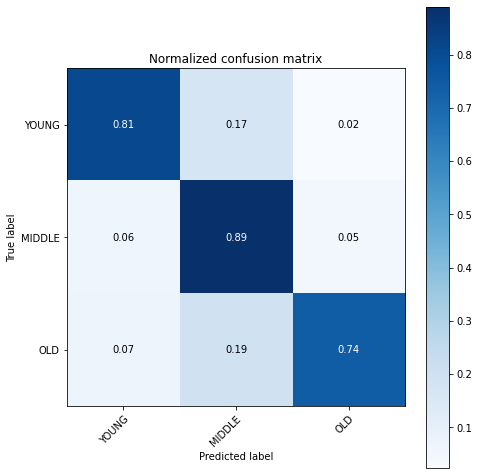

In [21]:
# plotting confusion matrix with normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')